In [1]:
# Environment setup
import sys
from pathlib import Path

# Add src to path
workspace_root = Path.cwd()
while not (workspace_root / 'src').exists() and workspace_root != workspace_root.parent:
    workspace_root = workspace_root.parent

sys.path.insert(0, str(workspace_root / 'src'))

print(f"Project root: {workspace_root}")
print(f"Python version: {sys.version}")
print("✓ Environment configured")

Project root: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Python version: 3.12.0 (v3.12.0:0fb18b02c8, Oct  2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]
✓ Environment configured


In [2]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
import warnings
warnings.filterwarnings('ignore')

# Thesis pipeline utilities
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All imports successful")

✓ All imports successful


## 1. Load Stance-Labeled Data

Load comments with stance predictions from notebook 16b.

In [3]:
# Paths
stance_path = workspace_root / 'data' / '03_stance' / 'reddit'
polarization_path = workspace_root / 'data' / '04_polarization' / 'reddit'
polarization_path.mkdir(parents=True, exist_ok=True)

print(f"Stance data: {stance_path}")
print(f"Polarization output: {polarization_path}")

# Load comments with stance labels
stance_file = stance_path / 'comments_with_stance.parquet'
if not stance_file.exists():
    raise FileNotFoundError(
        f"Stance-labeled data not found: {stance_file}\n"
        "Please run notebook 16b first to generate stance predictions."
    )

print(f"\n✓ Found stance-labeled data: {stance_file}")

Stance data: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/reddit
Polarization output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/reddit

✓ Found stance-labeled data: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/reddit/comments_with_stance.parquet


In [26]:
# Load data
print("Loading stance-labeled comments...")
df = read_parquet(stance_file)

print(f"\n✓ Loaded {len(df):,} comments")
print(f"\nDate range: {df['created_utc'].min()} to {df['created_utc'].max()}")
print(f"\nColumns: {df.columns.tolist()}")

# Show available columns
print(f"\nStance-related columns:")
stance_cols = [col for col in df.columns if 'stance' in col.lower()]
for col in stance_cols:
    print(f"  - {col}")

Loading stance-labeled comments...

✓ Loaded 86,974 comments

Date range: 1472689104 to 1477958326

Columns: ['comment_id', 'submission_id', 'body', 'created_utc', 'parent_id', 'thread_topic', 'sim_climate_change', 'sim_donald_trump', 'sim_gun_control', 'sim_immigration', 'sim_vaccination', 'stance_label', 'stance_label_id', 'stance_prob_pro', 'stance_prob_against', 'stance_prob_neutral', 'stance_confidence']

Stance-related columns:
  - stance_label
  - stance_label_id
  - stance_prob_pro
  - stance_prob_against
  - stance_prob_neutral
  - stance_confidence


In [13]:
# Data overview
print("Data overview:")
print(f"\nTopics: {df['thread_topic'].nunique()}")
print(df['thread_topic'].value_counts())

print(f"\nStance distribution:")
print(df['stance_label'].value_counts())
print(f"\nStance percentages:")
print(df['stance_label'].value_counts(normalize=True) * 100)

print(f"\nConfidence statistics:")
print(df['stance_confidence'].describe())

Data overview:

Topics: 5
thread_topic
donald_trump      53238
gun_control       17467
immigration        8988
climate_change     7048
vaccination         233
Name: count, dtype: int64

Stance distribution:
stance_label
against    51359
pro        19681
neutral    15934
Name: count, dtype: int64

Stance percentages:
stance_label
against    59.050981
pro        22.628602
neutral    18.320418
Name: proportion, dtype: float64

Confidence statistics:
count    86974.000000
mean         0.933945
std          0.121824
min          0.345514
25%          0.939293
50%          0.994533
75%          0.998641
max          0.999514
Name: stance_confidence, dtype: float64


## 2. Data Preparation

Prepare temporal aggregation and validate data quality.

In [39]:
from datetime import datetime
# Ensure datetime column is properly formatted
print(f"Original created_utc dtype: {df['created_utc'].dtype}")


df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', utc=True)

# Extract components
df['date'] = df['created_utc'].dt.date                    # Date only (YYYY-MM-DD)
df['week'] = df['created_utc'].dt.to_period('W')          # Week period object (has start_time)
df['year_month'] = df['created_utc'].dt.to_period('M').astype(str)  # YYYY-MM format


print("✓ Added temporal columns")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {(df['date'].max() - df['date'].min()).days}")
print(f"Total weeks: {df['week'].nunique()}")

Original created_utc dtype: datetime64[ns, UTC]
✓ Added temporal columns

Date range: 2016-09-01 to 2016-10-31
Total days: 60
Total weeks: 10


In [40]:
# Check for missing values
print("Checking for missing values...")
missing_stance = df['stance_label'].isna().sum()
missing_topic = df['thread_topic'].isna().sum()

print(f"\nMissing stance labels: {missing_stance}")
print(f"Missing topic labels: {missing_topic}")

if missing_stance > 0:
    print(f"\n⚠️  Warning: Removing {missing_stance} comments with missing stance labels")
    df = df[df['stance_label'].notna()].copy()

if missing_topic > 0:
    print(f"\n⚠️  Warning: Removing {missing_topic} comments with missing topic labels")
    df = df[df['thread_topic'].notna()].copy()

print(f"\n✓ Clean dataset: {len(df):,} comments")

Checking for missing values...

Missing stance labels: 0
Missing topic labels: 0

✓ Clean dataset: 86,974 comments


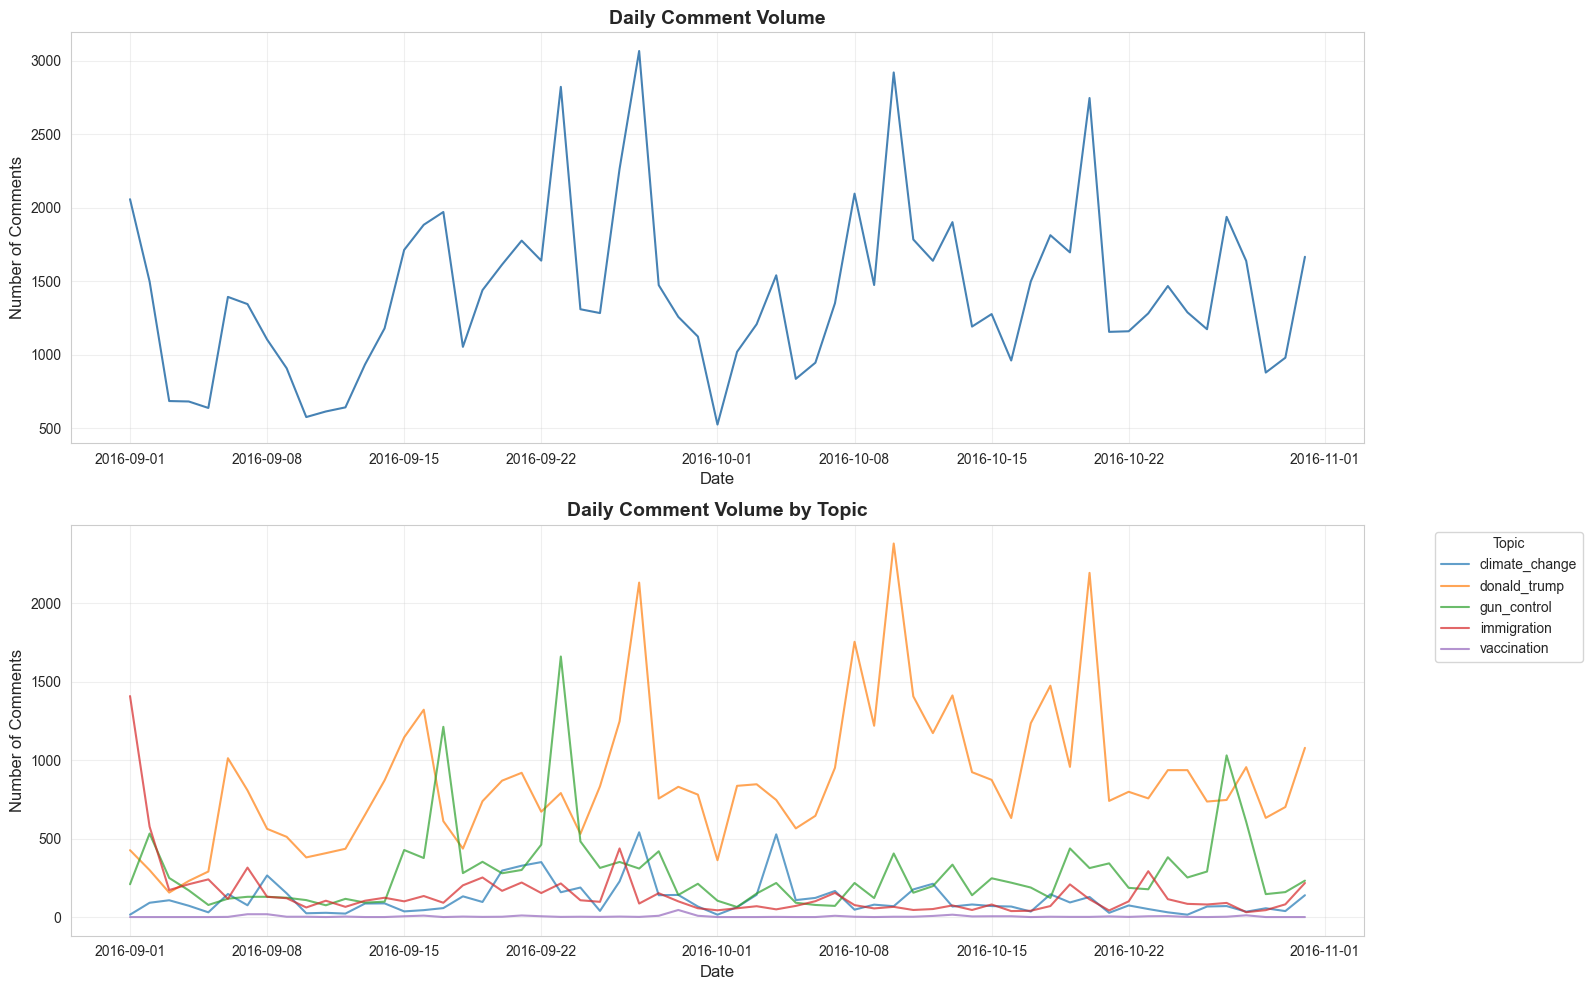

✓ Saved temporal coverage visualization


In [41]:
# Visualize temporal coverage
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Daily comment volume
ax1 = axes[0]
daily_counts = df.groupby('date').size()
daily_counts.plot(ax=ax1, color='steelblue', linewidth=1.5)
ax1.set_title('Daily Comment Volume', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Number of Comments', fontsize=12)
ax1.grid(alpha=0.3)

# Daily volume by topic
ax2 = axes[1]
daily_by_topic = df.groupby(['date', 'thread_topic']).size().unstack(fill_value=0)
daily_by_topic.plot(ax=ax2, linewidth=1.5, alpha=0.7)
ax2.set_title('Daily Comment Volume by Topic', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Number of Comments', fontsize=12)
ax2.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(polarization_path / 'temporal_coverage.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved temporal coverage visualization")

## 3. Esteban-Ray Polarization Implementation

Implement the Esteban-Ray (1994) polarization measure.

### Methodology

**Esteban-Ray Formula:**
$$P = K \sum_{i=1}^{n} \sum_{j=1}^{n} \pi_i^{1+\alpha} \pi_j |y_i - y_j|$$

**For Stance Detection Context:**
- **Groups**: pro, against, neutral
- **Positions on ideological scale**:
  - pro: +1.0 (supports topic)
  - against: -1.0 (opposes topic)
  - neutral: 0.0 (neutral/unclear)
- **α parameter**: 1.6 (standard value for polarization)
- **K normalization**: Set to 1.0 (or normalize to [0,1] range)

**Interpretation:**
- Higher values = more polarized
- Lower values = more consensus
- Considers both group sizes and ideological distance

In [42]:
def calculate_esteban_ray_polarization(stance_counts, alpha=1.6, positions=None):
    """
    Calculate Esteban-Ray polarization index for stance distribution.
    
    Parameters:
    -----------
    stance_counts : dict or pd.Series
        Counts of each stance (pro, against, neutral)
    alpha : float, default=1.6
        Polarization parameter (typically 1.0-2.0, standard is 1.6)
    positions : dict, optional
        Ideological positions for each stance
        Default: {'pro': 1.0, 'against': -1.0, 'neutral': 0.0}
    
    Returns:
    --------
    float : Esteban-Ray polarization index
    
    Notes:
    ------
    - Higher values indicate more polarization
    - Value range depends on stance distribution and alpha parameter
    - Returns 0.0 if insufficient data (< 2 comments)
    """
    # Default positions on ideological scale
    if positions is None:
        positions = {
            'pro': 1.0,
            'against': -1.0,
            'neutral': 0.0
        }
    
    # Convert to dict if Series
    if isinstance(stance_counts, pd.Series):
        stance_counts = stance_counts.to_dict()
    
    # Total comments
    total = sum(stance_counts.values())
    
    # Need at least 2 comments for polarization
    if total < 2:
        return 0.0
    
    # Calculate proportions
    proportions = {stance: count / total for stance, count in stance_counts.items()}
    
    # Calculate Esteban-Ray polarization
    polarization = 0.0
    
    for stance_i, pi in proportions.items():
        for stance_j, pj in proportions.items():
            # Get positions
            yi = positions.get(stance_i, 0.0)
            yj = positions.get(stance_j, 0.0)
            
            # Esteban-Ray formula: pi^(1+α) * pj * |yi - yj|
            polarization += (pi ** (1 + alpha)) * pj * abs(yi - yj)
    
    # K normalization constant (set to 1.0, or can normalize to [0,1])
    K = 1.0
    
    return K * polarization

print("✓ Esteban-Ray polarization function defined")

# Test the function
print("\nTesting polarization calculation:")
test_cases = [
    {'pro': 100, 'against': 100, 'neutral': 0},  # Maximum polarization
    {'pro': 100, 'against': 0, 'neutral': 0},     # Consensus (all pro)
    {'pro': 50, 'against': 50, 'neutral': 50},    # Mixed distribution
    {'pro': 33, 'against': 33, 'neutral': 34},    # Balanced
]

for i, test in enumerate(test_cases, 1):
    pol = calculate_esteban_ray_polarization(test)
    print(f"  Test {i}: {test} → Polarization = {pol:.4f}")

✓ Esteban-Ray polarization function defined

Testing polarization calculation:
  Test 1: {'pro': 100, 'against': 100, 'neutral': 0} → Polarization = 0.3299
  Test 2: {'pro': 100, 'against': 0, 'neutral': 0} → Polarization = 0.0000
  Test 3: {'pro': 50, 'against': 50, 'neutral': 50} → Polarization = 0.1533
  Test 4: {'pro': 33, 'against': 33, 'neutral': 34} → Polarization = 0.1519


In [43]:
def calculate_polarization_metrics(stance_series, alpha=1.6):
    """
    Calculate comprehensive polarization metrics for a stance distribution.
    
    Parameters:
    -----------
    stance_series : pd.Series
        Series of stance labels (pro, against, neutral)
    alpha : float
        Esteban-Ray alpha parameter
    
    Returns:
    --------
    dict : Dictionary with polarization metrics
    """
    # Count stances
    stance_counts = stance_series.value_counts().to_dict()
    total = len(stance_series)
    
    # Ensure all stances are represented
    for stance in ['pro', 'against', 'neutral']:
        if stance not in stance_counts:
            stance_counts[stance] = 0
    
    # Calculate proportions
    proportions = {stance: count / total for stance, count in stance_counts.items()}
    
    # Calculate Esteban-Ray polarization
    er_polarization = calculate_esteban_ray_polarization(stance_counts, alpha=alpha)
    
    # Calculate additional metrics
    # 1. Bipolarity: proportion of pro + against (excludes neutral)
    bipolarity = (proportions['pro'] + proportions['against'])
    
    # 2. Balance: how balanced are pro and against?
    #    1.0 = perfectly balanced, 0.0 = completely one-sided
    if proportions['pro'] + proportions['against'] > 0:
        balance = 1 - abs(proportions['pro'] - proportions['against']) / (proportions['pro'] + proportions['against'])
    else:
        balance = 0.0
    
    # 3. Extremism: proportion in extreme positions (pro or against, not neutral)
    extremism = 1 - proportions['neutral']
    
    return {
        'total_comments': total,
        'er_polarization': er_polarization,
        'bipolarity': bipolarity,
        'balance': balance,
        'extremism': extremism,
        'prop_pro': proportions['pro'],
        'prop_against': proportions['against'],
        'prop_neutral': proportions['neutral'],
        'count_pro': stance_counts['pro'],
        'count_against': stance_counts['against'],
        'count_neutral': stance_counts['neutral']
    }

print("✓ Polarization metrics function defined")

✓ Polarization metrics function defined


## 4. Calculate Polarization by Topic

Calculate overall polarization for each topic.

In [44]:
# Calculate polarization for each topic
print("Calculating polarization by topic...")

topic_polarization = []

for topic in df['thread_topic'].unique():
    topic_data = df[df['thread_topic'] == topic]
    metrics = calculate_polarization_metrics(topic_data['stance_label'])
    metrics['topic'] = topic
    topic_polarization.append(metrics)

topic_pol_df = pd.DataFrame(topic_polarization)

print("\n" + "="*80)
print("POLARIZATION BY TOPIC")
print("="*80)
print("\n", topic_pol_df[[
    'topic', 'total_comments', 'er_polarization', 
    'bipolarity', 'balance', 'extremism'
]].to_string(index=False))

# Sort by polarization
topic_pol_df = topic_pol_df.sort_values('er_polarization', ascending=False)

print("\n" + "="*80)
print("RANKING (by Esteban-Ray Polarization)")
print("="*80)
for i, row in enumerate(topic_pol_df.itertuples(), 1):
    print(f"\n{i}. {row.topic}")
    print(f"   Polarization: {row.er_polarization:.4f}")
    print(f"   Bipolarity: {row.bipolarity:.3f} | Balance: {row.balance:.3f} | Extremism: {row.extremism:.3f}")
    print(f"   Distribution: {row.prop_pro:.1%} pro, {row.prop_against:.1%} against, {row.prop_neutral:.1%} neutral")

Calculating polarization by topic...

POLARIZATION BY TOPIC

          topic  total_comments  er_polarization  bipolarity  balance  extremism
   immigration            8988         0.238706    0.890521 0.657171   0.890521
  donald_trump           53238         0.174995    0.741219 0.407947   0.741219
   gun_control           17467         0.198661    0.951108 0.286884   0.951108
climate_change            7048         0.101765    0.958428 0.089119   0.958428
   vaccination             233         0.213200    0.888412 0.405797   0.888412

RANKING (by Esteban-Ray Polarization)

1. immigration
   Polarization: 0.2387
   Bipolarity: 0.891 | Balance: 0.657 | Extremism: 0.891
   Distribution: 29.3% pro, 59.8% against, 10.9% neutral

2. vaccination
   Polarization: 0.2132
   Bipolarity: 0.888 | Balance: 0.406 | Extremism: 0.888
   Distribution: 70.8% pro, 18.0% against, 11.2% neutral

3. gun_control
   Polarization: 0.1987
   Bipolarity: 0.951 | Balance: 0.287 | Extremism: 0.951
   Distributio

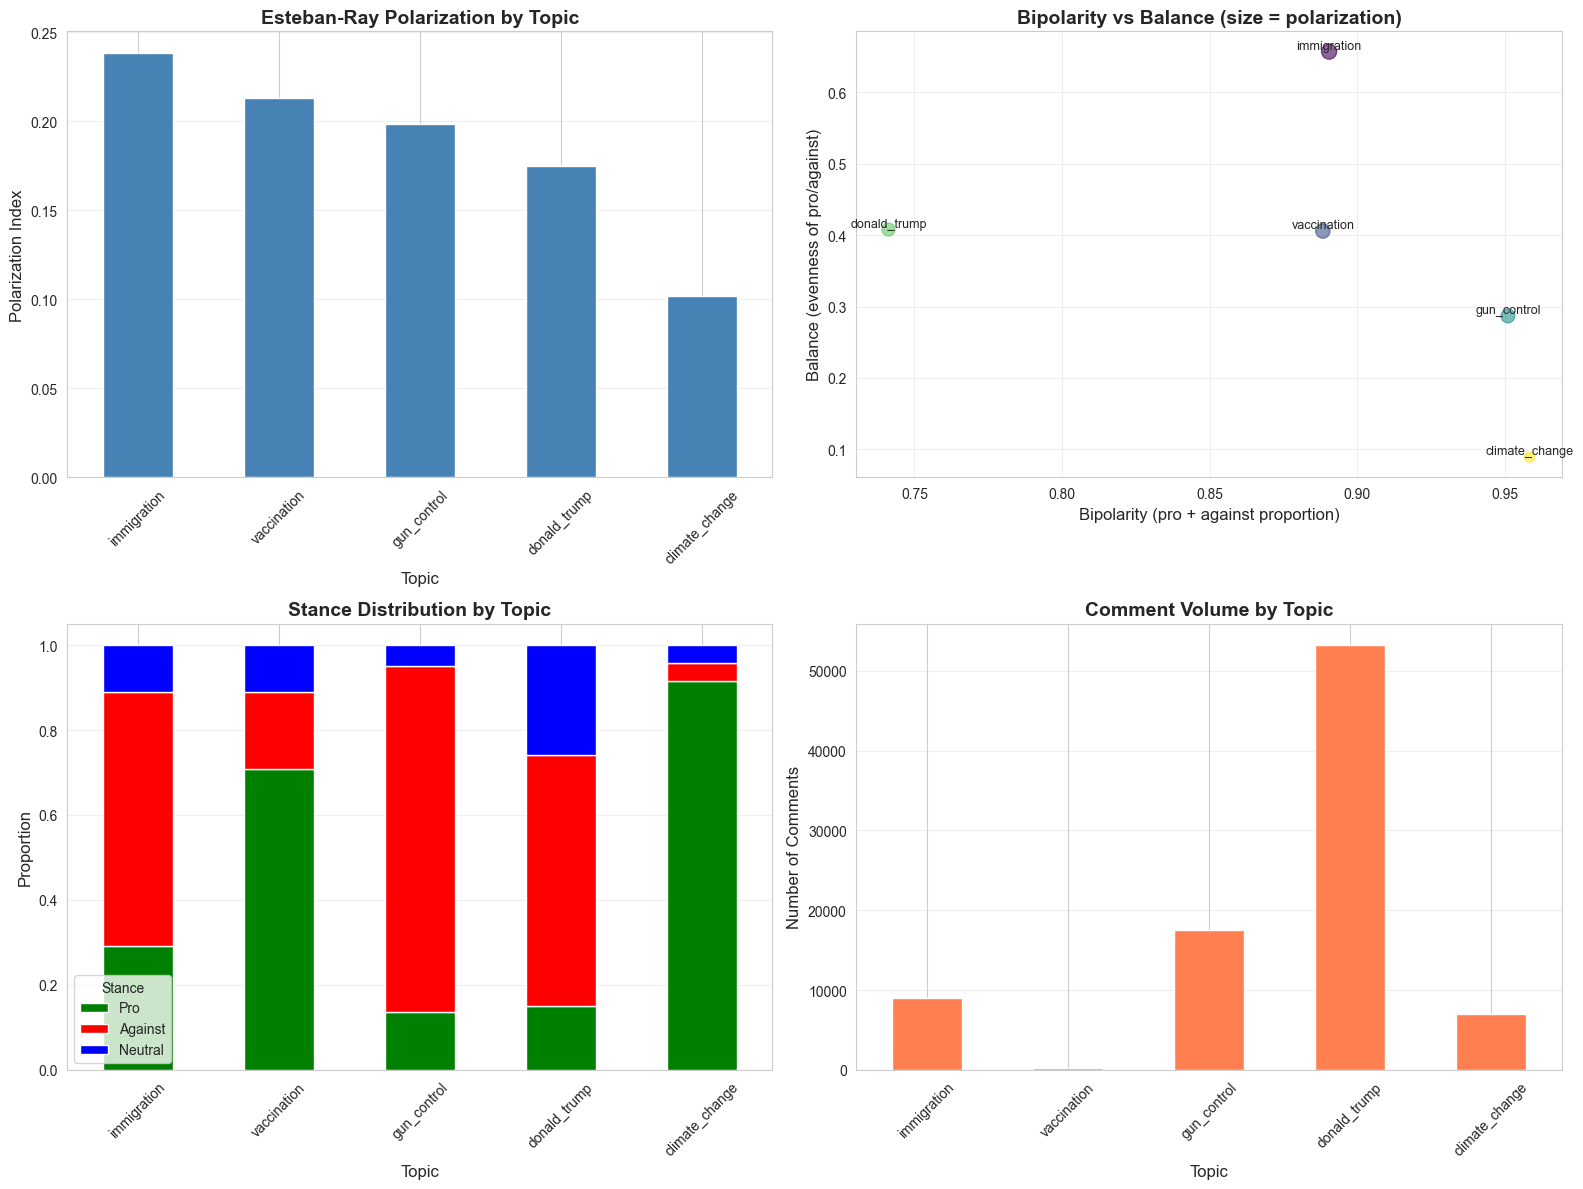

✓ Saved polarization visualizations


In [45]:
# Visualize topic polarization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Esteban-Ray Polarization by topic
ax = axes[0, 0]
topic_pol_df.plot(x='topic', y='er_polarization', kind='bar', ax=ax, color='steelblue', legend=False)
ax.set_title('Esteban-Ray Polarization by Topic', fontsize=14, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Polarization Index', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# 2. Bipolarity vs Balance
ax = axes[0, 1]
scatter = ax.scatter(
    topic_pol_df['bipolarity'], 
    topic_pol_df['balance'],
    s=topic_pol_df['er_polarization']*500,  # Size by polarization
    alpha=0.6,
    c=range(len(topic_pol_df)),
    cmap='viridis'
)
for _, row in topic_pol_df.iterrows():
    ax.annotate(
        row['topic'],
        (row['bipolarity'], row['balance']),
        fontsize=9,
        ha='center',
        va='bottom'
    )
ax.set_title('Bipolarity vs Balance (size = polarization)', fontsize=14, fontweight='bold')
ax.set_xlabel('Bipolarity (pro + against proportion)', fontsize=12)
ax.set_ylabel('Balance (evenness of pro/against)', fontsize=12)
ax.grid(alpha=0.3)

# 3. Stance distribution by topic
ax = axes[1, 0]
stance_props = topic_pol_df[['topic', 'prop_pro', 'prop_against', 'prop_neutral']].set_index('topic')
stance_props.plot(kind='bar', stacked=True, ax=ax, color=['green', 'red', 'blue'])
ax.set_title('Stance Distribution by Topic', fontsize=14, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)
ax.legend(title='Stance', labels=['Pro', 'Against', 'Neutral'])
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# 4. Comment volume by topic
ax = axes[1, 1]
topic_pol_df.plot(x='topic', y='total_comments', kind='bar', ax=ax, color='coral', legend=False)
ax.set_title('Comment Volume by Topic', fontsize=14, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Number of Comments', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(polarization_path / 'polarization_by_topic.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved polarization visualizations")

## 5. Calculate Temporal Polarization (Daily)

Calculate polarization over time for trend analysis and forecasting.

In [46]:
# Calculate daily polarization by topic
print("Calculating daily polarization time series...")

daily_polarization = []

for topic in df['thread_topic'].unique():
    topic_data = df[df['thread_topic'] == topic]
    
    for date, date_data in topic_data.groupby('date'):
        metrics = calculate_polarization_metrics(date_data['stance_label'])
        metrics['topic'] = topic
        metrics['date'] = date
        daily_polarization.append(metrics)

daily_pol_df = pd.DataFrame(daily_polarization)
daily_pol_df = daily_pol_df.sort_values(['topic', 'date'])

print(f"\n✓ Calculated polarization for {len(daily_pol_df):,} topic-date combinations")
print(f"\nDate range: {daily_pol_df['date'].min()} to {daily_pol_df['date'].max()}")
print(f"Topics: {daily_pol_df['topic'].nunique()}")

# Summary statistics
print("\nDaily polarization summary:")
print(daily_pol_df[['er_polarization', 'bipolarity', 'balance', 'extremism']].describe())

Calculating daily polarization time series...

✓ Calculated polarization for 285 topic-date combinations

Date range: 2016-09-01 to 2016-10-31
Topics: 5

Daily polarization summary:
       er_polarization  bipolarity     balance   extremism
count       285.000000  285.000000  285.000000  285.000000
mean          0.168590    0.873735    0.350840    0.873735
std           0.074139    0.145410    0.260588    0.145410
min           0.000000    0.000000    0.000000    0.000000
25%           0.130073    0.797101    0.116054    0.797101
50%           0.177380    0.929577    0.345946    0.929577
75%           0.219930    0.960000    0.479167    0.960000
max           0.329877    1.000000    1.000000    1.000000


In [47]:
# Filter days with minimum comment threshold
MIN_COMMENTS_PER_DAY = 10  # Minimum comments for reliable polarization estimate

daily_pol_filtered = daily_pol_df[daily_pol_df['total_comments'] >= MIN_COMMENTS_PER_DAY].copy()

print(f"Filtering days with < {MIN_COMMENTS_PER_DAY} comments...")
print(f"\nBefore: {len(daily_pol_df):,} topic-dates")
print(f"After:  {len(daily_pol_filtered):,} topic-dates")
print(f"Removed: {len(daily_pol_df) - len(daily_pol_filtered):,} ({(len(daily_pol_df) - len(daily_pol_filtered))/len(daily_pol_df)*100:.1f}%)")

print("\nDays per topic (after filtering):")
print(daily_pol_filtered.groupby('topic').size())

Filtering days with < 10 comments...

Before: 285 topic-dates
After:  250 topic-dates
Removed: 35 (12.3%)

Days per topic (after filtering):
topic
climate_change    61
donald_trump      61
gun_control       61
immigration       61
vaccination        6
dtype: int64


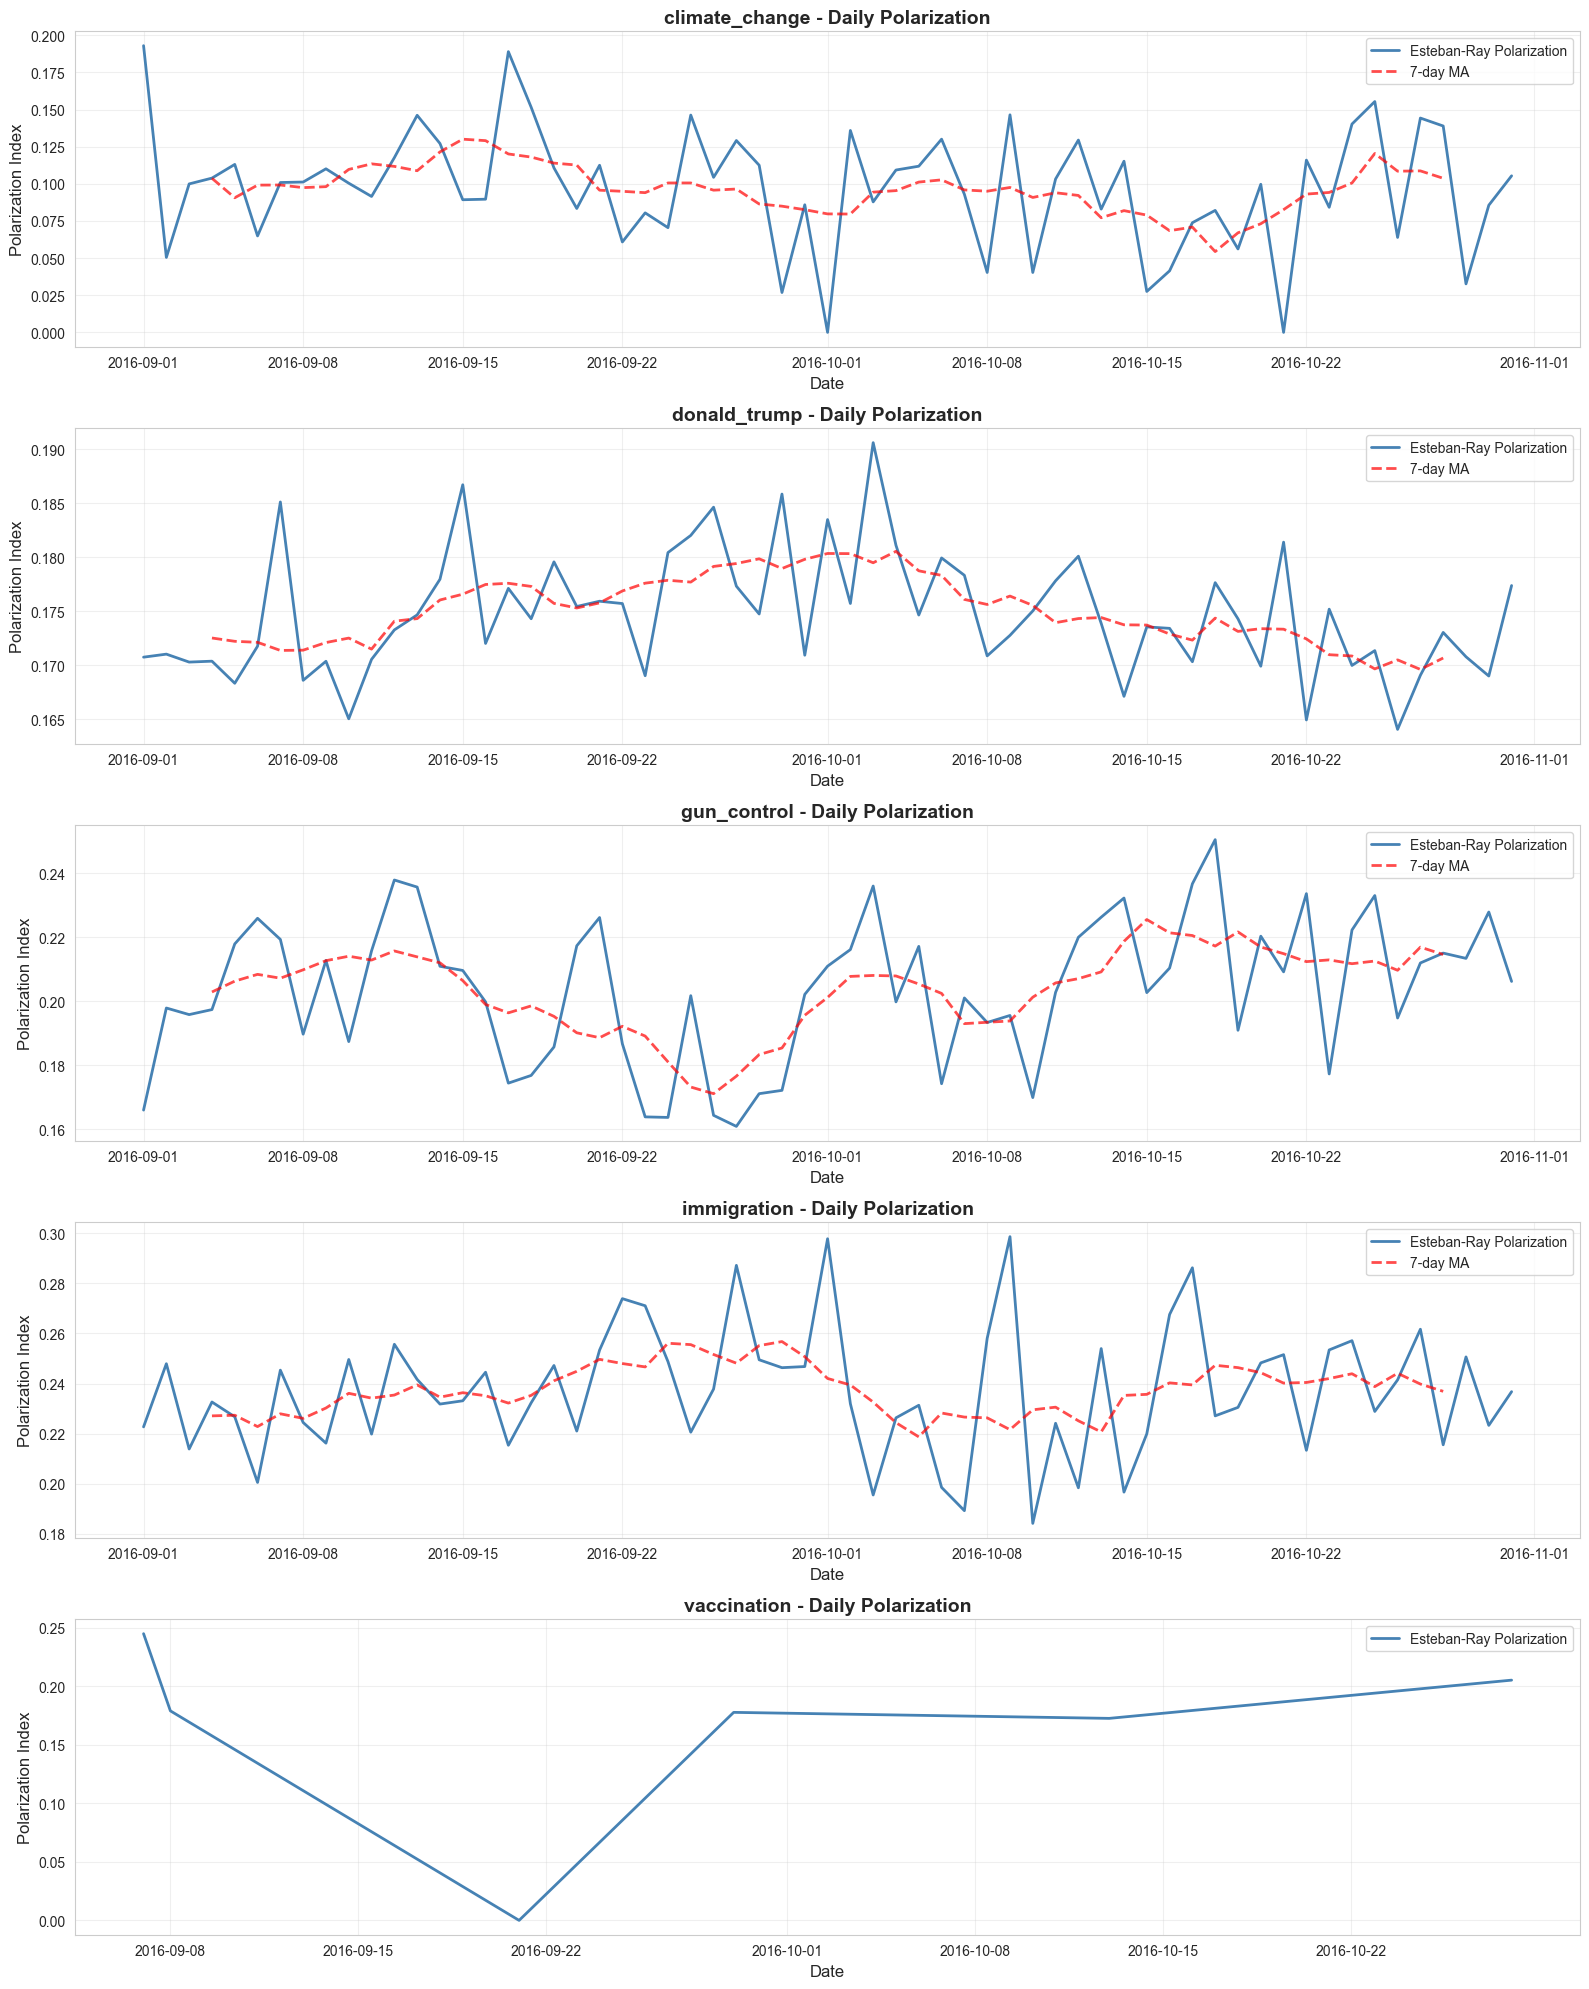

✓ Saved daily polarization time series


In [48]:
# Visualize daily polarization time series
topics = daily_pol_filtered['topic'].unique()
n_topics = len(topics)

fig, axes = plt.subplots(n_topics, 1, figsize=(16, 4*n_topics))
if n_topics == 1:
    axes = [axes]

for ax, topic in zip(axes, topics):
    topic_data = daily_pol_filtered[daily_pol_filtered['topic'] == topic].copy()
    topic_data = topic_data.sort_values('date')
    
    # Plot polarization
    ax.plot(topic_data['date'], topic_data['er_polarization'], 
            linewidth=2, color='steelblue', label='Esteban-Ray Polarization')
    
    # Add 7-day moving average
    if len(topic_data) >= 7:
        ma7 = topic_data['er_polarization'].rolling(window=7, center=True).mean()
        ax.plot(topic_data['date'], ma7, 
                linewidth=2, color='red', linestyle='--', alpha=0.7, label='7-day MA')
    
    ax.set_title(f'{topic} - Daily Polarization', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Polarization Index', fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(polarization_path / 'daily_polarization_time_series.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved daily polarization time series")

## 6. Calculate Temporal Polarization (Weekly)

Weekly aggregation for smoother trends and forecasting.

In [49]:
# Calculate weekly polarization by topic
print("Calculating weekly polarization time series...")

weekly_polarization = []

for topic in df['thread_topic'].unique():
    topic_data = df[df['thread_topic'] == topic]
    
    for week, week_data in topic_data.groupby('week'):
        metrics = calculate_polarization_metrics(week_data['stance_label'])
        metrics['topic'] = topic
        metrics['week'] = week
        metrics['week_start'] = week.start_time
        weekly_polarization.append(metrics)

weekly_pol_df = pd.DataFrame(weekly_polarization)
weekly_pol_df = weekly_pol_df.sort_values(['topic', 'week'])

print(f"\n✓ Calculated polarization for {len(weekly_pol_df):,} topic-week combinations")
print(f"\nWeek range: {weekly_pol_df['week'].min()} to {weekly_pol_df['week'].max()}")
print(f"Total weeks: {weekly_pol_df['week'].nunique()}")

# Filter weeks with minimum comments
MIN_COMMENTS_PER_WEEK = 30
weekly_pol_filtered = weekly_pol_df[weekly_pol_df['total_comments'] >= MIN_COMMENTS_PER_WEEK].copy()

print(f"\nFiltering weeks with < {MIN_COMMENTS_PER_WEEK} comments...")
print(f"After filtering: {len(weekly_pol_filtered):,} topic-weeks")
print("\nWeeks per topic:")
print(weekly_pol_filtered.groupby('topic').size())

Calculating weekly polarization time series...

✓ Calculated polarization for 48 topic-week combinations

Week range: 2016-08-29/2016-09-04 to 2016-10-31/2016-11-06
Total weeks: 10

Filtering weeks with < 30 comments...
After filtering: 43 topic-weeks

Weeks per topic:
topic
climate_change    10
donald_trump      10
gun_control       10
immigration       10
vaccination        3
dtype: int64


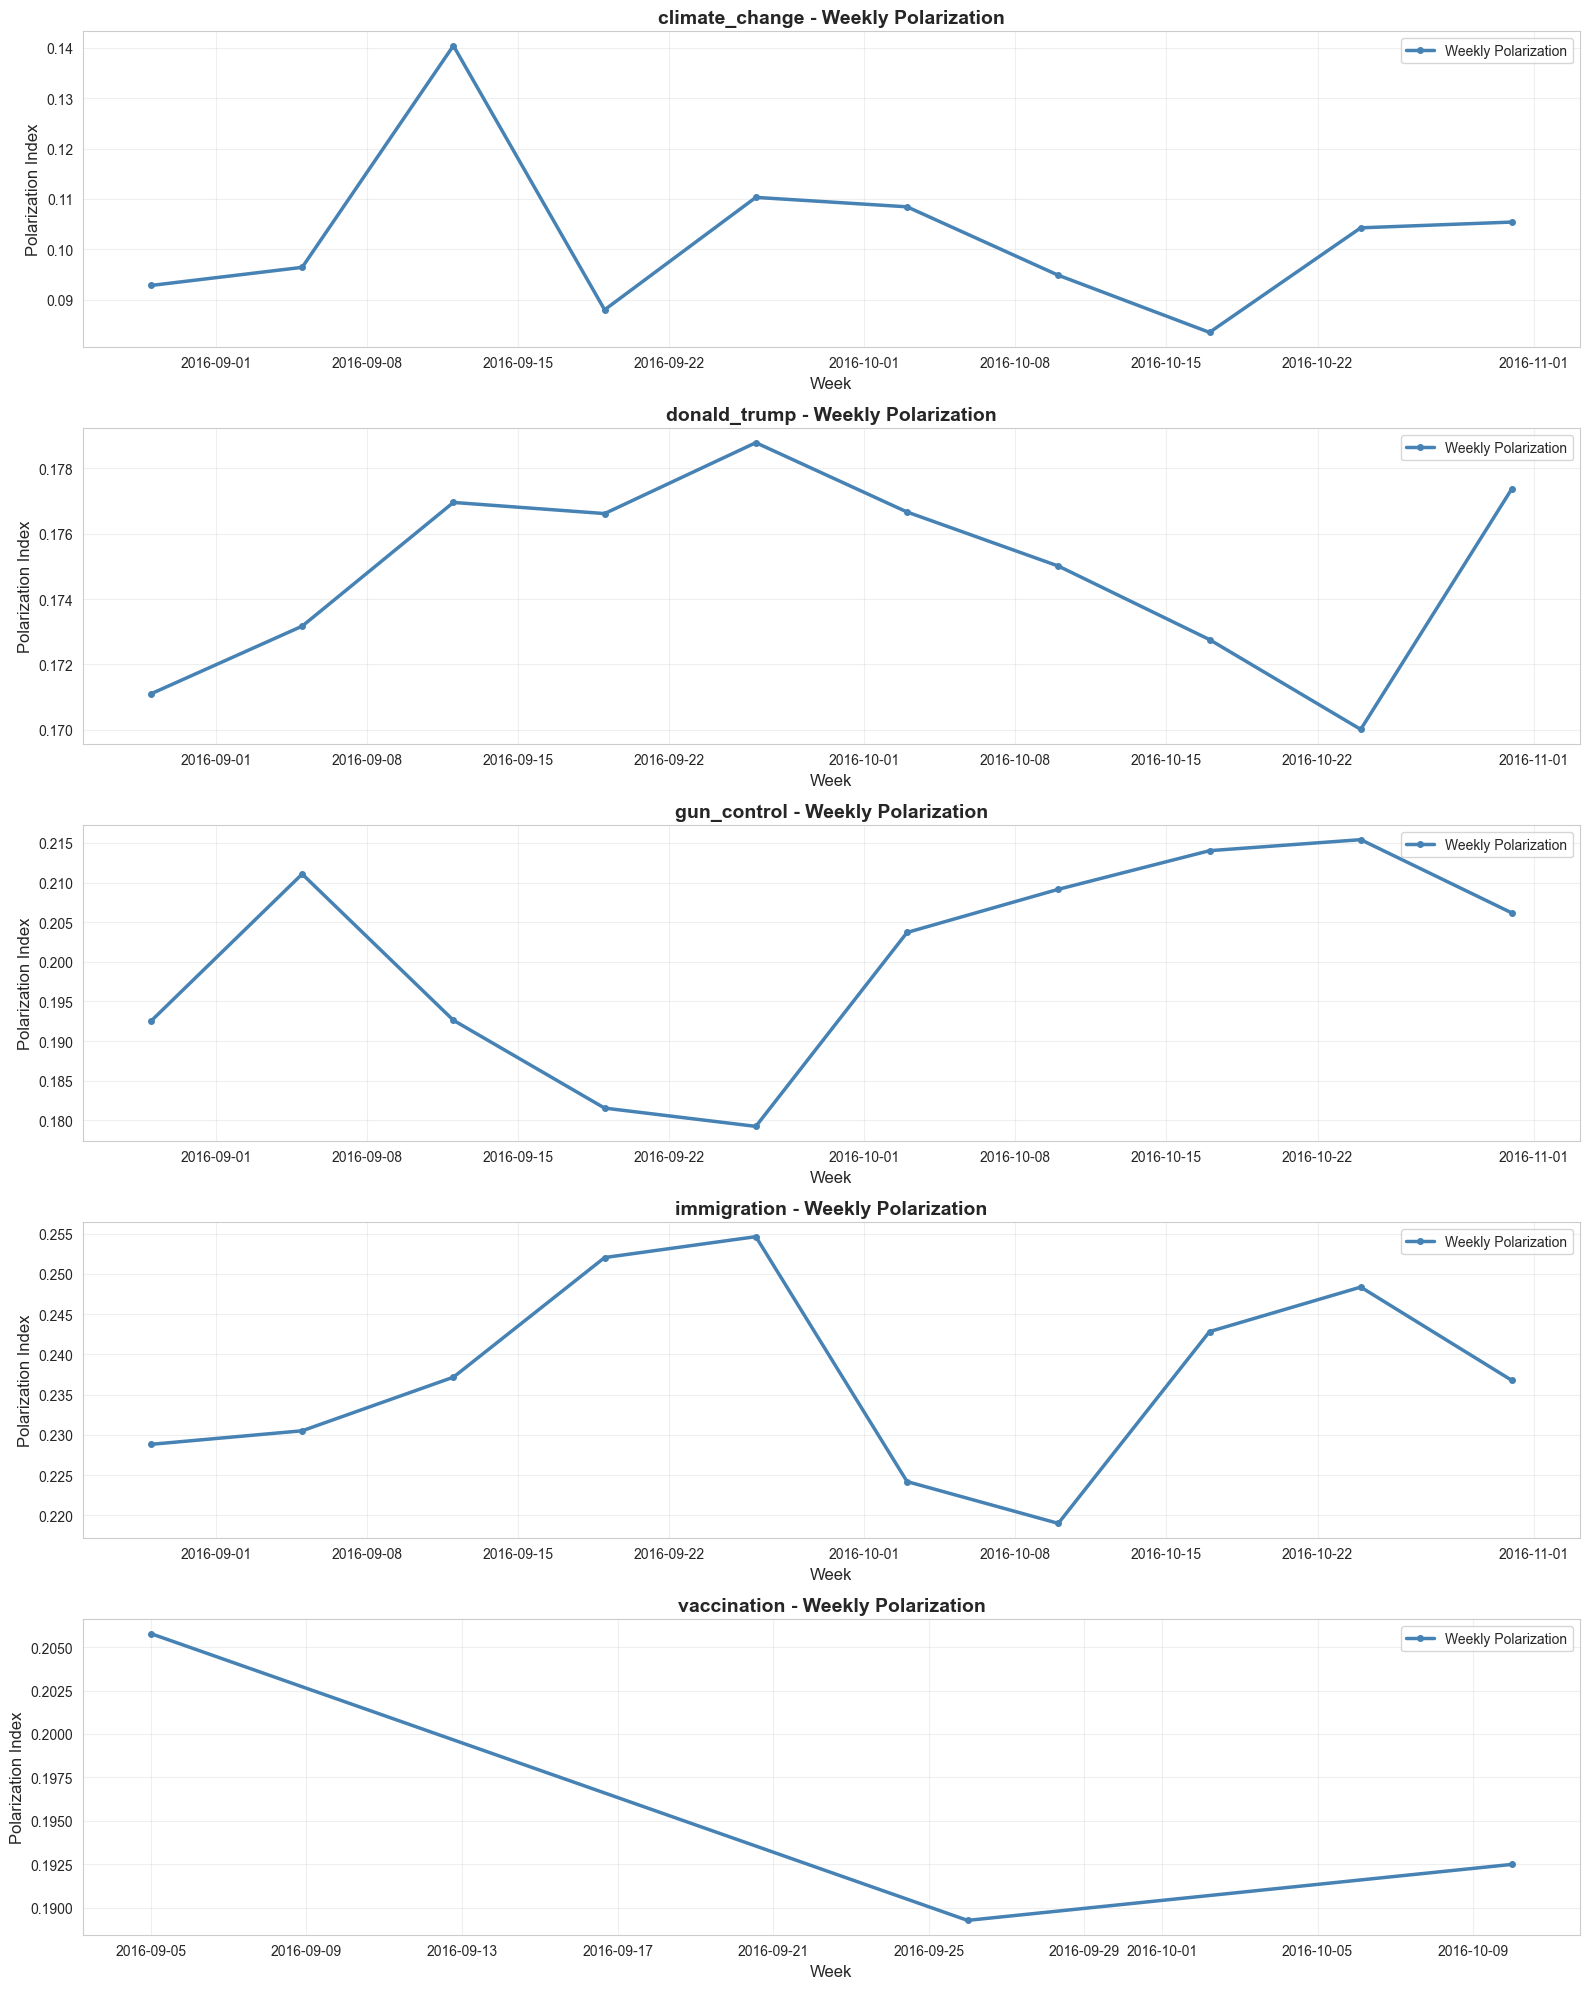

✓ Saved weekly polarization time series


In [50]:
# Visualize weekly polarization time series
topics = weekly_pol_filtered['topic'].unique()
n_topics = len(topics)

fig, axes = plt.subplots(n_topics, 1, figsize=(16, 4*n_topics))
if n_topics == 1:
    axes = [axes]

for ax, topic in zip(axes, topics):
    topic_data = weekly_pol_filtered[weekly_pol_filtered['topic'] == topic].copy()
    topic_data = topic_data.sort_values('week_start')
    
    # Plot polarization
    ax.plot(topic_data['week_start'], topic_data['er_polarization'], 
            linewidth=2.5, color='steelblue', marker='o', markersize=4, 
            label='Weekly Polarization')
    
    ax.set_title(f'{topic} - Weekly Polarization', fontsize=14, fontweight='bold')
    ax.set_xlabel('Week', fontsize=12)
    ax.set_ylabel('Polarization Index', fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(polarization_path / 'weekly_polarization_time_series.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved weekly polarization time series")

## 7. Polarization Correlation Analysis

Analyze relationships between polarization metrics and other variables.

Analyzing correlations between polarization metrics...



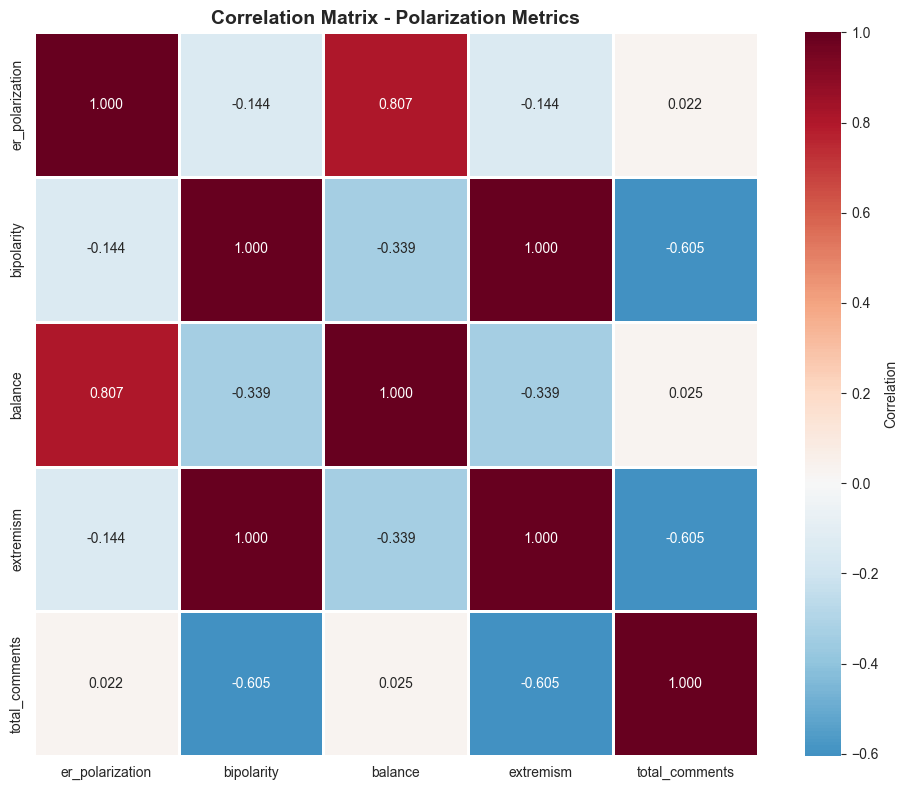


Correlation with Esteban-Ray Polarization:
er_polarization    1.000000
balance            0.806631
total_comments     0.022246
extremism         -0.143691
bipolarity        -0.143691
Name: er_polarization, dtype: float64


In [51]:
# Correlation between polarization metrics
print("Analyzing correlations between polarization metrics...\n")

metrics_cols = ['er_polarization', 'bipolarity', 'balance', 'extremism', 'total_comments']
corr_matrix = daily_pol_filtered[metrics_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={'label': 'Correlation'}
)
plt.title('Correlation Matrix - Polarization Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(polarization_path / 'polarization_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCorrelation with Esteban-Ray Polarization:")
print(corr_matrix['er_polarization'].sort_values(ascending=False))

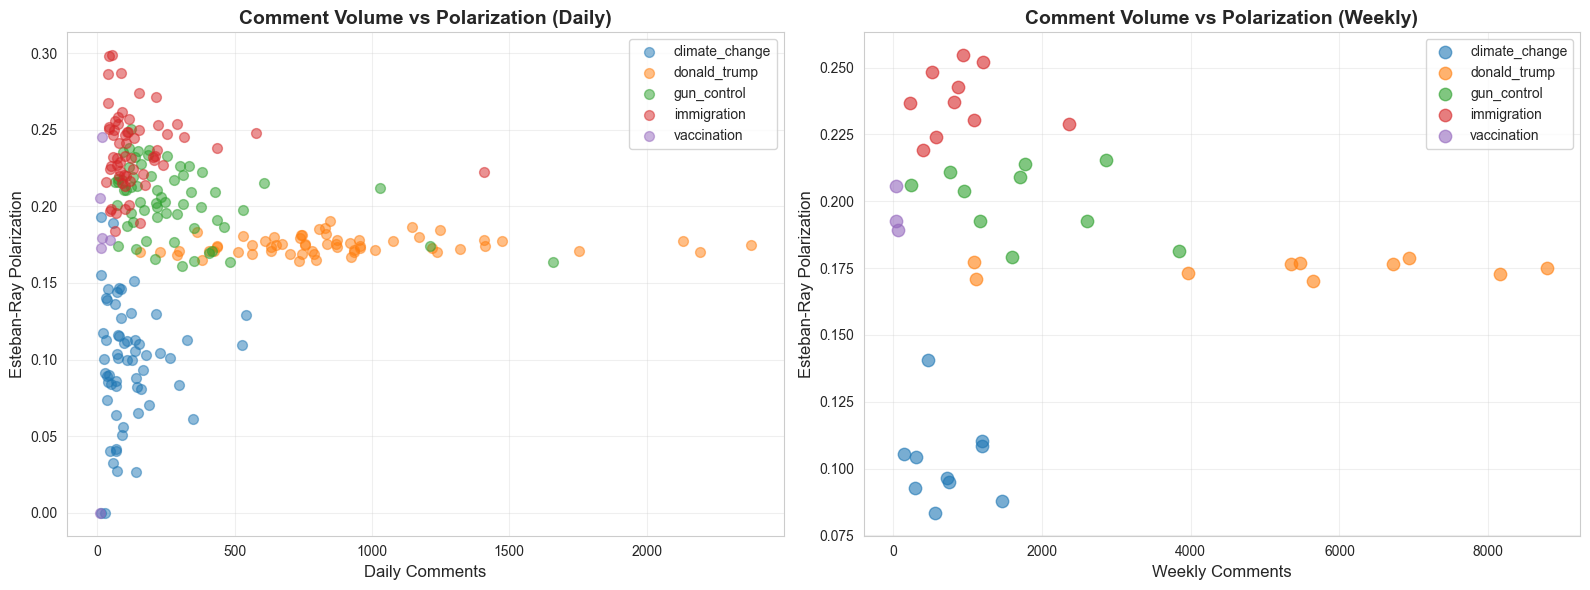

✓ Saved volume vs polarization analysis


In [52]:
# Relationship between volume and polarization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Daily volume vs polarization
ax = axes[0]
for topic in daily_pol_filtered['topic'].unique():
    topic_data = daily_pol_filtered[daily_pol_filtered['topic'] == topic]
    ax.scatter(
        topic_data['total_comments'],
        topic_data['er_polarization'],
        alpha=0.5,
        label=topic,
        s=50
    )
ax.set_title('Comment Volume vs Polarization (Daily)', fontsize=14, fontweight='bold')
ax.set_xlabel('Daily Comments', fontsize=12)
ax.set_ylabel('Esteban-Ray Polarization', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

# Weekly volume vs polarization
ax = axes[1]
for topic in weekly_pol_filtered['topic'].unique():
    topic_data = weekly_pol_filtered[weekly_pol_filtered['topic'] == topic]
    ax.scatter(
        topic_data['total_comments'],
        topic_data['er_polarization'],
        alpha=0.6,
        label=topic,
        s=80
    )
ax.set_title('Comment Volume vs Polarization (Weekly)', fontsize=14, fontweight='bold')
ax.set_xlabel('Weekly Comments', fontsize=12)
ax.set_ylabel('Esteban-Ray Polarization', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(polarization_path / 'volume_vs_polarization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved volume vs polarization analysis")

## 8. Save Results

Save polarization time series for forecasting (RQ3-4).

In [53]:
# Save topic-level polarization
topic_pol_file = polarization_path / 'polarization_by_topic.parquet'
write_parquet(topic_pol_df, topic_pol_file)
print(f"✓ Saved topic polarization: {topic_pol_file}")

# Save daily polarization time series
daily_pol_file = polarization_path / 'polarization_daily.parquet'
write_parquet(daily_pol_filtered, daily_pol_file)
print(f"✓ Saved daily polarization: {daily_pol_file}")

# Save weekly polarization time series
weekly_pol_file = polarization_path / 'polarization_weekly.parquet'
write_parquet(weekly_pol_filtered, weekly_pol_file)
print(f"✓ Saved weekly polarization: {weekly_pol_file}")

print(f"\nAll files saved to: {polarization_path}")

✓ Wrote 5 rows to polarization_by_topic.parquet (0.0 MB)
✓ Saved topic polarization: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/reddit/polarization_by_topic.parquet
✓ Wrote 250 rows to polarization_daily.parquet (0.0 MB)
✓ Saved daily polarization: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/reddit/polarization_daily.parquet
✓ Wrote 43 rows to polarization_weekly.parquet (0.0 MB)
✓ Saved weekly polarization: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/reddit/polarization_weekly.parquet

All files saved to: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/reddit


In [54]:
# Save summary statistics as JSON
summary = {
    'notebook': '17_polarization_esteban_ray',
    'timestamp': datetime.now().isoformat(),
    'data_period': {
        'start_date': str(df['date'].min()),
        'end_date': str(df['date'].max()),
        'total_days': int((df['date'].max() - df['date'].min()).days)
    },
    'overall_stats': {
        'total_comments': int(len(df)),
        'topics': list(df['thread_topic'].unique()),
        'stance_distribution': df['stance_label'].value_counts().to_dict()
    },
    'polarization_method': {
        'metric': 'Esteban-Ray (1994)',
        'alpha': 1.6,
        'positions': {'pro': 1.0, 'against': -1.0, 'neutral': 0.0}
    },
    'topic_polarization': topic_pol_df.to_dict('records'),
    'daily_series': {
        'total_days': int(len(daily_pol_filtered)),
        'min_comments_threshold': MIN_COMMENTS_PER_DAY,
        'mean_polarization': float(daily_pol_filtered['er_polarization'].mean()),
        'std_polarization': float(daily_pol_filtered['er_polarization'].std())
    },
    'weekly_series': {
        'total_weeks': int(len(weekly_pol_filtered)),
        'min_comments_threshold': MIN_COMMENTS_PER_WEEK,
        'mean_polarization': float(weekly_pol_filtered['er_polarization'].mean()),
        'std_polarization': float(weekly_pol_filtered['er_polarization'].std())
    },
    'limitations': [
        'Stance detection model has limited performance (F1 ~0.40-0.50)',
        'donald_trump topic particularly weak (F1 0.22)',
        'Results are for pipeline validation only',
        'Final thesis requires improved stance model (F1 > 0.60)'
    ]
}

summary_file = polarization_path / '17_polarization_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"✓ Saved summary: {summary_file}")

✓ Saved summary: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/reddit/17_polarization_summary.json


## 9. Summary

Final summary of polarization analysis.

In [55]:
# Print final summary
print("\n" + "="*80)
print("POLARIZATION ANALYSIS COMPLETE")
print("="*80)

print(f"\n📊 DATA SUMMARY:")
print(f"  Total comments analyzed: {len(df):,}")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Topics: {df['thread_topic'].nunique()}")

print(f"\n📈 POLARIZATION METRICS:")
print(f"  Method: Esteban-Ray (1994) with α=1.6")
print(f"  Daily time points: {len(daily_pol_filtered):,} (≥{MIN_COMMENTS_PER_DAY} comments/day)")
print(f"  Weekly time points: {len(weekly_pol_filtered):,} (≥{MIN_COMMENTS_PER_WEEK} comments/week)")

print(f"\n🏆 MOST POLARIZED TOPICS:")
for i, row in topic_pol_df.head(3).iterrows():
    print(f"  {i+1}. {row['topic']}: {row['er_polarization']:.4f}")

print(f"\n✅ OUTPUTS CREATED:")
print(f"  • {topic_pol_file.name}")
print(f"  • {daily_pol_file.name}")
print(f"  • {weekly_pol_file.name}")
print(f"  • {summary_file.name}")
print(f"  • 5 visualization files")

print("\n" + "="*80)
print("⚠️  IMPORTANT LIMITATIONS")
print("="*80)

print("\n🚨 INHERITED FROM STANCE DETECTION:")
print("   • Stance model F1 ~0.40-0.50 (target: >0.60)")
print("   • donald_trump topic F1 ~0.22 (very poor)")
print("   • Polarization metrics inherit stance prediction errors")
print("\n📋 STATUS: Pipeline validation only, not final results")
print("\n❗ FOR FINAL THESIS:")
print("   • Improve stance detection model first")
print("   • Re-calculate polarization with better stance labels")
print("   • Current results demonstrate methodology, not findings")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)

print("\n1. VALIDATE POLARIZATION METRICS:")
print("   - Review time series for anomalies")
print("   - Check if trends make intuitive sense")
print("   - Examine high/low polarization days")

print("\n2. PREPARE FOR FORECASTING (RQ3-4):")
print("   - Use weekly polarization time series")
print("   - Test various forecasting models (ARIMA, Prophet, LSTM)")
print("   - Evaluate forecast accuracy")

print("\n3. FOR FINAL THESIS:")
print("   - Improve stance detection (500-1000 annotations, F1 >0.60)")
print("   - Re-run polarization calculation")
print("   - Conduct final forecasting analysis")
print("   - Document all limitations in methodology section")

print("\n" + "="*80)


POLARIZATION ANALYSIS COMPLETE

📊 DATA SUMMARY:
  Total comments analyzed: 86,974
  Date range: 2016-09-01 to 2016-10-31
  Topics: 5

📈 POLARIZATION METRICS:
  Method: Esteban-Ray (1994) with α=1.6
  Daily time points: 250 (≥10 comments/day)
  Weekly time points: 43 (≥30 comments/week)

🏆 MOST POLARIZED TOPICS:
  1. immigration: 0.2387
  5. vaccination: 0.2132
  3. gun_control: 0.1987

✅ OUTPUTS CREATED:
  • polarization_by_topic.parquet
  • polarization_daily.parquet
  • polarization_weekly.parquet
  • 17_polarization_summary.json
  • 5 visualization files

⚠️  IMPORTANT LIMITATIONS

🚨 INHERITED FROM STANCE DETECTION:
   • Stance model F1 ~0.40-0.50 (target: >0.60)
   • donald_trump topic F1 ~0.22 (very poor)
   • Polarization metrics inherit stance prediction errors

📋 STATUS: Pipeline validation only, not final results

❗ FOR FINAL THESIS:
   • Improve stance detection model first
   • Re-calculate polarization with better stance labels
   • Current results demonstrate methodology,